## Real-Time Script
Historical Data Date Range - exact 12 months back from today


Analaysis Data Date Range - today

### For one currency pair - USDEUR

In [1]:
import requests
import pandas as pd

def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
today = pd.Timestamp.now().date()
start_date = today - pd.DateOffset(years=1)
start_date_formatted = start_date.strftime('%Y-%m-%d')
end_date = today - pd.DateOffset(days=1)
end_date_formatted = end_date.strftime('%Y-%m-%d')
historical_url = f'https://api.polygon.io/v2/aggs/ticker/C:USDEUR/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
real_time_url = f'https://api.polygon.io/v2/aggs/ticker/C:USDEUR/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")

# Fetch and process real-time data
real_time_data = fetch_data(real_time_url)
if real_time_data and 'results' in real_time_data:
    real_time_df = pd.DataFrame(real_time_data['results'])
    real_time_df = convert_timestamps(real_time_df)
    # Use the last close from historical data
    last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
    real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
    real_time_df['source'] = 'real-time'
    updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
    # Update historical data
    historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
else:
    print("No new data available or failed to fetch real-time data.")
    
# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df])

# Print the Outliers
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
123,90791,0.9272,0.93437,0.91925,0.93517,0.918274,90791,2023-11-14,0.93442,-0.016235,0.016235,historical
114,87882,0.9359,0.94197,0.93120,0.94204,0.930300,87882,2023-11-03,0.94196,-0.011423,0.011423,historical
15,82724,0.9033,0.90794,0.89759,0.90807,0.897300,82724,2023-07-12,0.90793,-0.011389,0.011389,historical
251,71362,0.9271,0.92060,0.93098,0.93204,0.920000,71362,2024-04-10,0.92087,0.010979,0.010979,historical
150,123989,0.9140,0.91884,0.90960,0.91917,0.908100,123989,2023-12-14,0.91886,-0.010078,0.010078,historical
71,122190,0.9351,0.93168,0.94025,0.94056,0.929627,122190,2023-09-14,0.93167,0.009209,0.009209,historical
28,156010,0.9048,0.90266,0.91087,0.91190,0.896620,156010,2023-07-27,0.90267,0.009084,0.009084,historical
166,88179,0.9105,0.90604,0.91388,0.91419,0.905300,88179,2024-01-02,0.90604,0.008653,0.008653,historical
301,68754,0.9214,0.91812,0.92580,0.92593,0.917000,68754,2024-06-07,0.91811,0.008376,0.008376,historical
95,128469,0.9448,0.94127,0.94914,0.95001,0.939673,128469,2023-10-12,0.94126,0.008372,0.008372,historical


### Visualizing the Outliers

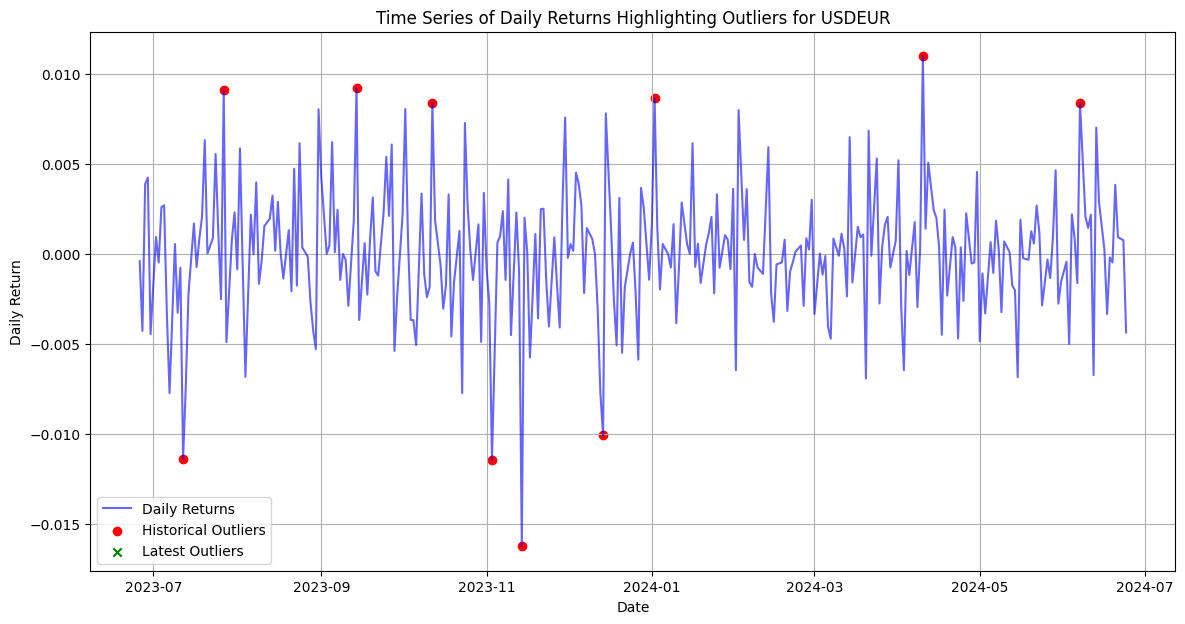

In [2]:
import matplotlib.pyplot as plt

def plot_data_with_outliers(historical_df, historical_outliers_df, real_time_outliers_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df['date'], historical_df['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(historical_outliers_df['date'], historical_outliers_df['daily_return'], color='red', label='Historical Outliers')
    plt.scatter(real_time_outliers_df['date'], real_time_outliers_df['daily_return'], color='green', label='Latest Outliers', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDEUR')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(historical_df, updated_historical_outliers_df, updated_real_time_outliers_df)

### Data Augmentation

In [3]:
def mark_outliers(historical_df, outliers_df):
    historical_df['outlier'] = 0
    outlier_dates = outliers_df['date'].values
    historical_df.loc[historical_df['date'].isin(outlier_dates), 'outlier'] = 1
    return historical_df

full_data_df = mark_outliers(historical_df, pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df]))

full_data_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source,outlier
1,66122,0.9168,0.91683,0.91650,0.91850,0.915416,66122,2023-06-26,0.91687,-0.000404,0.000404,historical,0
2,69255,0.9138,0.91656,0.91258,0.91724,0.911162,69255,2023-06-27,0.91650,-0.004277,0.004277,historical,0
3,74980,0.9144,0.91257,0.91612,0.91762,0.912000,74980,2023-06-28,0.91258,0.003879,0.003879,historical,0
4,78279,0.9179,0.91590,0.92000,0.92075,0.913700,78279,2023-06-29,0.91612,0.004235,0.004235,historical,0
5,75914,0.9186,0.92014,0.91590,0.92285,0.914495,75914,2023-06-30,0.92000,-0.004457,0.004457,historical,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,48013,0.9309,0.93119,0.93046,0.93241,0.929700,48013,2024-06-19,0.93090,-0.000473,0.000473,historical,0
312,58853,0.9325,0.93049,0.93403,0.93444,0.930100,58853,2024-06-20,0.93046,0.003837,0.003837,historical,0
313,59643,0.9350,0.93402,0.93490,0.93709,0.932600,59643,2024-06-21,0.93403,0.000931,0.000931,historical,0
314,2193,0.9353,0.93503,0.93561,0.93566,0.934940,2193,2024-06-23,0.93490,0.000759,0.000759,historical,0


In [4]:
full_data_df.to_csv("Outlier Dataset.csv")

### Data Augmentation